In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
n_points = 41
domain_size = 1.0
domain_size_y = 1.0
n_iterations = 500
time_step_length = 0.001
kinematic_viscosity = 0.01
density = 1.0
horizontal_velocity = 1.0
n_pressure_poisson_iterations = 50

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 194.54it/s]


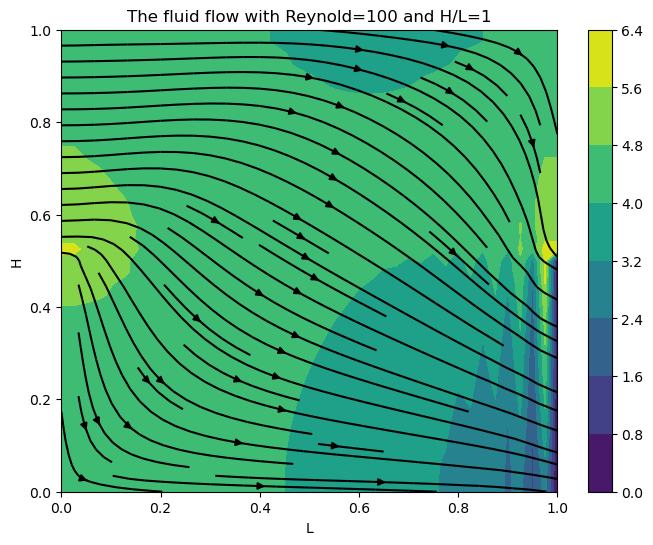

In [3]:
def main():
    element_length = domain_size / (n_points - 1)
    element_length_y = domain_size_y / (n_points - 1)
    x = np.linspace(0.0, domain_size, n_points)
    y = np.linspace(0.0, domain_size_y, n_points)
    
    X, Y = np.meshgrid(x, y)
    
    u_prev = np.zeros_like(X)
    v_prev = np.zeros_like(X)
    p_prev = np.zeros_like(X)
    
    def central_difference_x(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[1:-1, 2: ]-f[1:-1, 0:-2]) / (2 * element_length)
        return diff
    
    def central_difference_y(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[2: , 1:-1]-f[0:-2, 1:-1]) / (2 * element_length_y)
        return diff
    
    def laplace(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[1:-1, 0:-2]+f[0:-2, 1:-1]-4*f[1:-1, 1:-1]+f[1:-1, 2: ]+f[2: , 1:-1]) / (element_length*element_length_y)
        return diff
    
    for _ in tqdm(range(n_iterations)):
        d_u_prev_d_x = central_difference_x(u_prev)
        d_u_prev_d_y = central_difference_y(u_prev)
        d_v_prev_d_x = central_difference_x(v_prev)
        d_v_prev_d_y = central_difference_y(v_prev)
        laplace_u_prev = laplace(u_prev)
        laplace_v_prev = laplace(v_prev)
        
        u_tent = (u_prev + time_step_length * (-(u_prev + d_u_prev_d_x + v_prev + d_u_prev_d_y) + kinematic_viscosity 
                                               * laplace_u_prev))
        
        v_tent = (v_prev + time_step_length * (-(u_prev + d_v_prev_d_x + v_prev + d_v_prev_d_y) + kinematic_viscosity 
                                               * laplace_v_prev))
        
        
        u_tent[0, :] = 0.0
        u_tent[0:20, 0] = 0.0
        u_tent[21:40, 0] = 1.0
        u_tent[:, -1] = 0.0
        u_tent[-1 , :] = 0.0
        v_tent[0, :] = 0.0
        v_tent[:, 0] = 0.0
        v_tent[:, -1] = 0.0
        v_tent[-1, :] = 0.0
        
        d_u_tent_d_x = central_difference_x(u_tent)
        d_v_tent_d_y = central_difference_y(v_tent)
        
        rhs = (density / time_step_length * (d_u_tent_d_x + d_v_tent_d_y))
        
        for _ in range(n_pressure_poisson_iterations):
            p_next = np.zeros_like(p_prev)
            p_next[1:-1, 1:-1] = 1/4 * (+p_prev[1:-1, 0:-2] + p_prev[0:-2, 1:-1] + p_prev[1:-1, 2: ] + p_prev[2: , 1:-1] 
                                        - element_length**2 * rhs[1:-1, 1:-1])
            
            p_next[0:20, -1] = 0.0
            p_next[21:40, -1] = p_next[21:40, -2]
            p_next[0, :] = p_next[1, :]
            p_next[:, 0] = p_next[:, 1]
            p_next[-1, :] = p_next[-2, :]
        
            
            p_prev = p_next
            
        d_p_next_d_x = central_difference_x(p_next)
        d_p_next_d_y = central_difference_y(p_next)
        
        u_next = (u_tent - time_step_length / density * d_p_next_d_x)
        v_next = (v_tent - time_step_length / density * d_p_next_d_y)
        
        u_next[0, :] = 0.0
        u_next[0:20, 0] = 0.0
        u_next[21:40, 0] = 1.0
        u_next[: , -1] = 0.0
        u_next[-1 , :] = 0.0
        v_next[0, :] = 0.0
        v_next[:, 0] = 0.0
        v_next[:, -1] = 0.0
        v_next[-1, :] = 0.0
        
        u_prev = u_next
        v_prev = v_next
        p_prev = p_next
        

    plt.figure(figsize = (8, 6))
    plt.title('The fluid flow with Reynold=100 and H/L=1')
    plt.xlabel('L')
    plt.ylabel('H')
    plt.contourf(X, Y, p_next)
    plt.colorbar()
        
    plt.streamplot(X, Y, u_next, v_next, color="black")
    #plt.quiver(X, Y, u_next, v_next, color="black")
    plt.show()

            

if __name__=="__main__":
    main()